In [ ]:
from copy import deepcopy

import numpy as np
from numpy import asarray, sqrt, eye, abs as npabs, kron, pi, ndarray, append
from matplotlib.pyplot import subplots, show

from pytreenet.core import Node
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.operators import TensorProduct, Hamiltonian, pauli_matrices
from pytreenet.ttno import TreeTensorNetworkOperator

from pytreenet.time_evolution.bug import BUG
from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution
from pytreenet.time_evolution.ttn_time_evolution import TTNTimeEvolutionConfig
from pytreenet.util.tensor_splitting import SVDParameters

## Single Qubit

### Preparation

In [5]:
time_step_size = 0.01
final_time = 3.2

## Y and Z Gates

In [6]:
dim = 2
y_node_id = "Node_Y"
y_state = asarray([1.0, 0.0], dtype=complex)
y_node = Node(identifier=y_node_id)
y_ttns = TreeTensorNetworkState()
y_ttns.add_root(y_node, y_state)

z_node_id = "Node_Z"
z_state = asarray([1.0, 0.0], dtype=complex)
z_node = Node(identifier=z_node_id)
z_ttns = TreeTensorNetworkState()
z_ttns.add_root(z_node, z_state)

print(z_ttns.tensors)
print(z_ttns.nodes)

{'Node_Z': array([1.+0.j, 0.+0.j])}
{'Node_Z': <pytreenet.core.node.Node object at 0x00000221FD895430>}


In [7]:
X = pauli_matrices()[0]
Y = pauli_matrices()[1]
Z = pauli_matrices()[2]

identity = eye(dim)

Generate Y-Hamiltonian TTNO

In [ ]:
y_term = TensorProduct({y_node_id: "Y"})
y_conv_dict = {"I2": identity, "Y": Y}
y_hamiltonian = Hamiltonian(y_term, conversion_dictionary=y_conv_dict)
y_ttno = TreeTensorNetworkOperator.from_hamiltonian(y_hamiltonian, y_ttns)
print(y_ttno.tensors)
print(y_ttno.nodes)

{'Node': array([[0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j]])}
{'Node': <pytreenet.core.node.Node object at 0x0000014535B91880>}


Generate Z-Hamiltonian TTNO

In [ ]:
z_term = TensorProduct({z_node_id: "Z"})
z_conv_dict = {"I2": identity, "Z": Z}
z_hamiltonian = Hamiltonian(z_term, conversion_dictionary=z_conv_dict)
z_ttno = TreeTensorNetworkOperator.from_hamiltonian(z_hamiltonian, z_ttns)
print(y_ttno.tensors)
print(y_ttno.nodes)

Generate Z-Operator

In [ ]:
sq_op_id = "SQ_Operator"
y_gate_z_op = {sq_op_id: TensorProduct({y_node_id: Z})}
z_gate_z_op = {sq_op_id: TensorProduct({z_node_id: Z})}

{'SQ_Operator': {'Node': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}}


### Simulation

In [ ]:
y_gate_bug = BUG(y_ttns, y_ttno, time_step_size, final_time, y_gate_z_op)
z_gate_bug = BUG(z_ttns, z_ttno, time_step_size, final_time, z_gate_z_op)

In [ ]:
y_gate_bug.run()
z_gate_bug.run()

### Reference Simulation

In [27]:
y_ref_state = asarray([1.0, 0.0], dtype=complex)
y_ref_ham = pauli_matrices()[1]
y_ref_op = {sq_op_id: pauli_matrices()[2]}

z_ref_state = asarray([1.0, 0.0], dtype=complex)
z_ref_ham = pauli_matrices()[2]
z_ref_op = {sq_op_id: pauli_matrices()[2]}

In [28]:
y_gate_exact = ExactTimeEvolution(y_ref_state, y_ref_ham, time_step_size, final_time, y_ref_op)
z_gate_exact = ExactTimeEvolution(z_ref_state, z_ref_ham, time_step_size, final_time, z_ref_op)

In [29]:
y_gate_exact.run()
z_gate_exact.run()

100%|██████████| 321/321 [00:00<00:00, 161454.80it/s]


### Evaluation and Plotting

In [36]:
y_gate_times = y_gate_exact.times()

In [ ]:
print("Sanity Check: ", y_gate_bug.results_real())
y_gate_results = y_gate_bug.operator_result(sq_op_id, realise=True)
y_gate_exact_results = y_gate_exact.operator_result(sq_op_id, realise=True)
y_gate_error = npabs(y_gate_results - y_gate_exact_results)

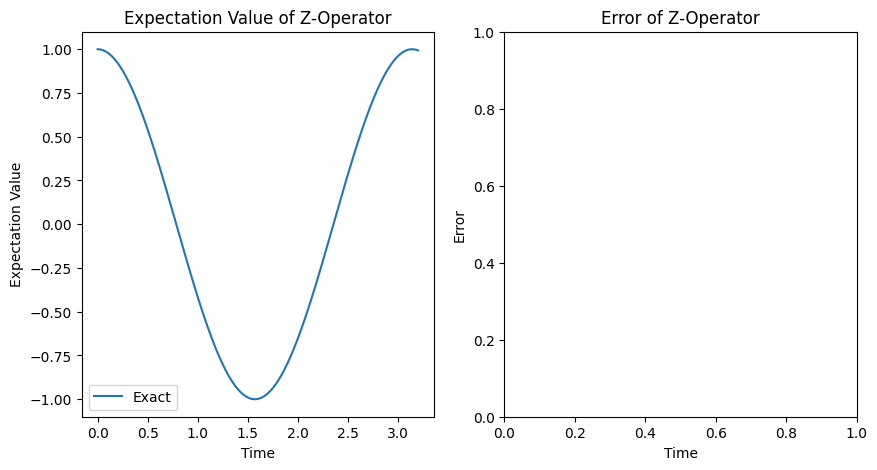

In [ ]:
fig, axs = subplots(1, 2, figsize=(10, 5))

axs[0].plot(y_gate_times, y_gate_results, label="BUG")
axs[0].plot(y_gate_times, y_gate_exact_results, label="Exact")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Expectation Value")
axs[0].set_title("Expectation Value of Z-Operator")
axs[0].legend()

axs[1].semilogy(y_gate_times, y_gate_error)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Error")
axs[1].set_title("Error of Z-Operator")

show()

In [32]:
z_gate_times = z_gate_exact.times()

In [ ]:
print("Sanity Check: ", z_gate_bug.results_real())
z_gate_results = z_gate_bug.operator_result(sq_op_id, realise=True)
z_gate_exact_results = z_gate_exact.operator_result(sq_op_id, realise=True)
z_gate_error = npabs(z_gate_results - z_gate_exact_results)

NameError: name 'z_gate_times' is not defined

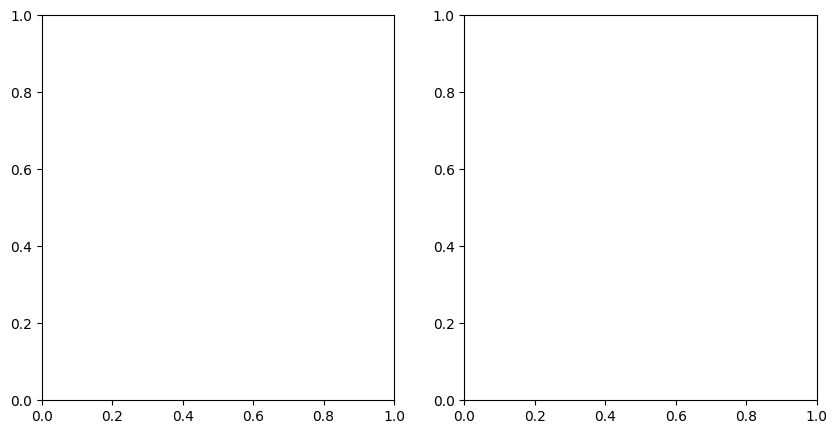

In [26]:
fig, axs = subplots(1, 2, figsize=(10, 5))

axs[0].plot(z_gate_times, z_gate_results, label="BUG")
axs[0].plot(z_gate_times, z_gate_exact_results, label="Exact")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Expectation Value")
axs[0].set_title("Expectation Value of Z-Operator")
axs[0].legend()

axs[1].semilogy(z_gate_times, z_gate_error)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Error")
axs[1].set_title("Error of Z-Operator")

show()

## Hadamard Gate

The Hadamard-Gate can be obtained from:
$$
\text{H} = e^{-i \frac{\pi}{2\sqrt{2}}(X + Z)}.
$$

In [4]:
hadmard_node_id = "Node_H"
h_state = asarray([1.0, 0.0], dtype=complex)
h_node = Node(identifier=hadmard_node_id)
h_ttns = TreeTensorNetworkState()
h_ttns.add_root(h_node, h_state)

print(h_ttns.tensors)
print(h_ttns.nodes)

{'Node_H': array([1.+0.j, 0.+0.j])}
{'Node_H': <pytreenet.core.node.Node object at 0x00000221FD5D8D10>}


Generate Hamadamrd-Hamiltonian TTNO

In [ ]:
h_term = TensorProduct({hadmard_node_id: "H"})
hadamard_gate = (1 / np.sqrt(2)) * (X + Z)
h_conv_dict = {"I2": identity, "H": hadamard_gate}
h_hamiltonian = Hamiltonian(h_term, conversion_dictionary=h_conv_dict)
h_ttno = TreeTensorNetworkOperator.from_hamiltonian(h_hamiltonian, h_ttns)
print(h_ttno.tensors)
print(h_ttno.nodes)

{'Node_H': array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]])}
{'Node_H': <pytreenet.core.node.Node object at 0x00000221FDB711C0>}


In [19]:
sq_op_id = "SQ_Operator"
h_z_op = {sq_op_id: TensorProduct({hadmard_node_id: Z})}
print(h_z_op)

{'SQ_Operator': {'Node_H': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}}


### Simulation

In [ ]:
h_bug = BUG(h_ttns, h_ttno, time_step_size, final_time, h_z_op)

In [ ]:
h_bug.run()

### Reference Simulation

In [20]:
h_ref_state = asarray([1.0, 0.0], dtype=complex)
h_ref_ham = (1 / np.sqrt(2)) * (X + Z)
h_ref_op = {sq_op_id: pauli_matrices()[2]}

In [21]:
h_exact = ExactTimeEvolution(h_ref_state, h_ref_ham, time_step_size, final_time, h_ref_op)

In [22]:
h_exact.run()

100%|██████████| 321/321 [00:00<00:00, 159996.62it/s]


### Evalutaion and Plotting

In [23]:
h_times = h_exact.times()

In [ ]:
print("Sanity Check: ", h_bug.results_real())
h_results = h_bug.operator_result(sq_op_id, realise=True)
h_exact_results = h_exact.operator_result(sq_op_id, realise=True)
h_error = npabs(h_results - h_exact_results)

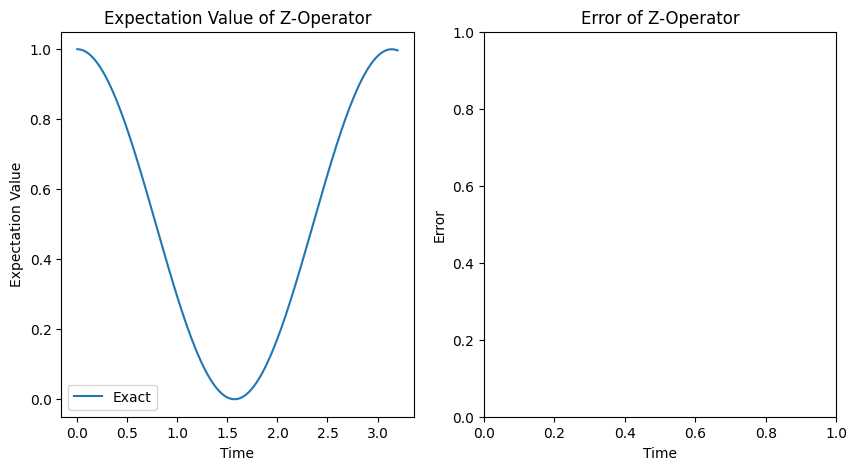

In [ ]:
fig, axs = subplots(1, 2, figsize=(10, 5))

axs[0].plot(h_times, h_results, label="BUG")
axs[0].plot(h_times, h_exact_results, label="Exact")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Expectation Value")
axs[0].set_title("Expectation Value of Z-Operator")
axs[0].legend()

axs[1].semilogy(h_times, h_error)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Error")
axs[1].set_title("Error of Z-Operator")

show()